## Moving Abroad - Choosing a new city to live

Moving abroad and choosing a new city to live is not easy. The following solution tackles this problem in three steps. First, the target city is chosen among the sister cities of the current city. Sister cities are cities that establish a bond of cooperation on many factors (culture, health, education, transport, and economic development) and are located in different countries, developing a paradiplomacy bond (relationship that does not depend on federal governments). Those cities are compared and segmented taking into consideration indexes like cost of living, rent, pollution, crime, health care, etc. The list of sister cities are obtained from Wikipedia and the indexes are obtained from Numbeo, the world's largest database on world living conditions.
  
Second, after the most proper city being chosen, the best neighborhood is selected. In this process, all the neighborhoods of the city are compared and segmented according to the most popular venues (restaurants, bars, museum, parks, beach, cinema, etc) existent in each one. Each neighborhood group is labeled according to the type of venues, allowing a characterization of each group, and them displayed in a map to facilitate the decision. The top venues of each neighborhood are obtained from Foursquare, a local search-and-discovery mobile app that provides personalized recommendations of places to go near a user's current location. The neighborhoods coordinates are obtained from Amsterdam municipal page.
  
Finally, a choropeth map of Amsterdam neighborhoods is generated taking into consideration the safety index, which measures how safety each neighborhood is. This map in then merged with the map obtained in the previous step resulting in a final map that shows the neighborhoods segmented by venues similarity, their top ten venues, and their safety index. Thus, visualizing this map, one can decide which neighborhood to live.

Before we get the data and start exploring it, let's download all the necessary dependencies.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         394 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5.

### 1. Choosing a new city to move in

Moving to another country is a task that requires deep research about the target city and typically takes into consideration different factors such as cultural life, attractions, language, climate, jog market, etc. Even after a detailed research, many expats decide to return to their home country due to difficulties adapting to the new city. Moving to a sister city can be easier, since they share some features and have political facilitators.
  
Sister cities are cities that establish a bond of cooperation on many factors like culture, health, education, transport, and economic development. Often the cities are located in different countries, developing a paradiplomacy relation, a relationship that does not depend on federal governments (which is what designates diplomacy). Typically, to become sisters two cities need to have similar features like number of habitants, historical facts or economic sector.
  
This study takes the Brazilian city of Recife as the hometown city. To obtain the Recife sister cities, Wikipedia is consulted. Any city page in Wikipedia presents a section called "sister cities", however it can vary depending on the language chosen. Naturally, there is more information in the language of the country the city belongs. In the case of Recife, Wikipedia in English lists only three sister cities while the Portuguese version shows eight. We got the Portuguese version list but we eliminated one of them because it is another Brazilian city and this study is about moving abroad. The final list is: Amsterdam, Aveiro, Guangzhou, Corunna, Nantes, Porto, and Venice.

The approach here is to compare those cities taking into consideration some living parameters. This information is obtained from Numbeo, the world’s largest database of user contributed data about cities and countries worldwide and provides current and timely information on world living conditions including cost of living, housing indicators, health care, traffic, etc. They formulated a index for each of those parameters: Cost of living, Rent, Property Price, Crime, Health Care, Pollution, Traffic, and Climate. The way those indexes are calculated can be find at Numbeo page. After an initial exploratory analysis, the cities are clustered based on those indexes to facilitate the decision of which one to move in.  

#### 1.1 Download and explore the dataset

The access to Numbeo's API is not free, but it has a page with all the information about those living indexes. As the amount of data is little and the API access is paid, the desired information was obtained accessing manually the Numbeo page and building a excel file with it.   

In [2]:
cities = pd.read_excel("numbeo.xlsx")
cities

,City,Cost of Living,Rent,Property Price,Crime,Health Care,Pollution,Traffic,Climate
0,Recife,31.31,7.51,20.56,76.81,60.95,69.85,193.11,79.28
1,Amsterdam,80.74,55.94,10.70,32.44,69.45,30.90,100.88,87.45
2,Aveiro,45.19,16.40,8.27,27.16,78.12,30.42,54.22,97.64
3,Guangzhou,39.78,17.11,34.11,40.08,65.29,76.05,133.40,80.30
4,Corunna,54.33,26.77,11.83,11.73,81.27,27.66,102.95,97.21
5,Nantes,70.40,22.09,8.95,52.75,81.52,29.26,84.27,91.59
6,Porto,49.82,24.35,12.62,36.87,74.62,36.02,111.47,96.61
7,Venice,79.90,33.49,13.50,31.99,68.35,68.78,0.00,82.39


Cost of Living and Rent indexes are calculated in relation to New York City. Which means that for New York City, each index should be 100(%). If another city has, for example, rent index of 120, it means that on an average in that city rents are 20% more expensive than in New York City. If a city has rent index of 70, that means on average rent in that city is 30% less expensive than in New York City. Each of the others indexes is calculated in a very specific way that can be verified at Numbeo webpage. 

#### When cheap becomes expensive

Cost of living and rent are the main factors that affect one expanses (here they are called **cost indexes**) and, thus, are essential in the decision of choosing a new city to move in. However, problems like crime, pollution and traffic can negatively influence the life experience in the new place and may be relevant to care about, thus, here they are called **negative indexes**. At the same time, the health care system and the climate are positive features that can also help in the decision (**positive indexes**). The following graphs compare those aspects among the cities. 

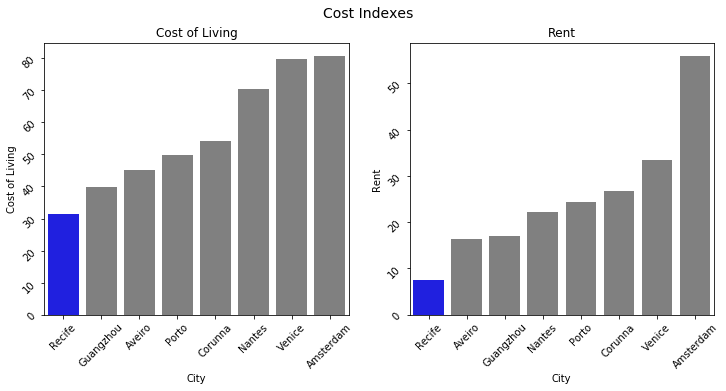

In [3]:
def print_cities_barplot(attr, axs, i, minmax):
    df = cities.sort_values(attr)
    y = df[attr]
    clrs = ['grey' if (x > min(y)) else 'blue' for x in y] if (minmax==0) else ['grey' if (x < max(y)) else 'blue' for x in y] #Set a different color to the lowest/highest bar
    sns.barplot(x='City', y=attr, data=df, palette = clrs, ax=axs[i])
    axs[i].tick_params(labelrotation=45)
    axs[i].set_title(attr, fontsize=12)
    
fig, axs = plt.subplots(ncols=2,figsize=(12, 5))
fig.suptitle('Cost Indexes', fontsize=14)
print_cities_barplot('Cost of Living', axs, 0, 0)
print_cities_barplot('Rent', axs, 1, 0)

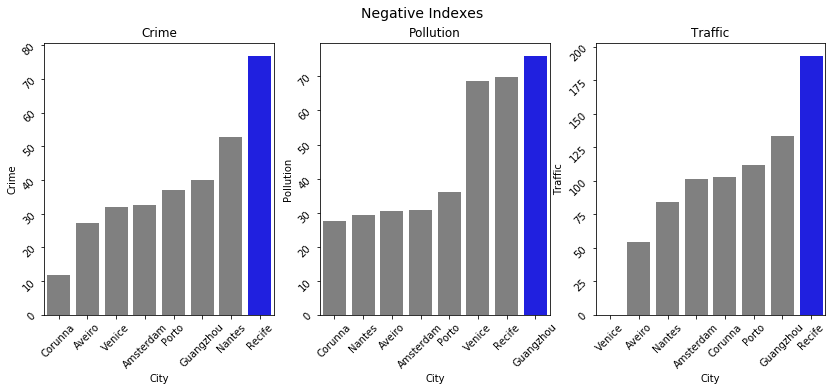

In [4]:
fig, axs = plt.subplots(ncols=3,figsize=(14, 5))
fig.suptitle('Negative Indexes', fontsize=14)
print_cities_barplot('Crime', axs, 0, 1)
print_cities_barplot('Pollution', axs, 1, 1)
print_cities_barplot('Traffic', axs, 2, 1)

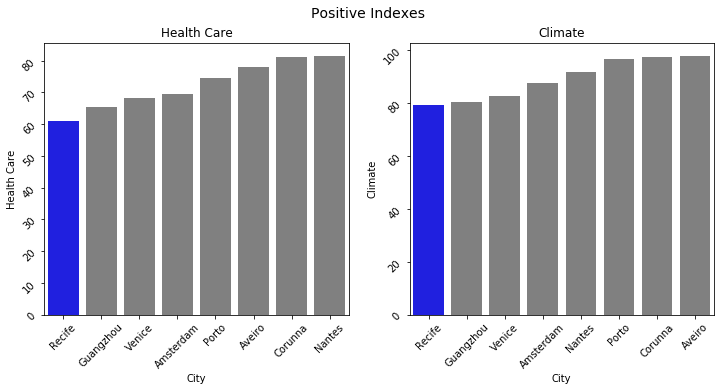

In [5]:
fig, axs = plt.subplots(ncols=2,figsize=(12, 5))
fig.suptitle('Positive Indexes', fontsize=14)
print_cities_barplot('Health Care', axs, 0, 0)
print_cities_barplot('Climate', axs, 1, 0)

As can be seen, Recife is the cheapest city to live. However, this come with a price. It presents the highest crime and pollution indexes, the second worst pollution index and lowest health care and climate indexes. At first look, one can imagine that the more expensive the city the better the quality life indicators, but this relation is not that direct and simple. Venice and Amsterdam, for example, are those with the highest cost of living and rent, however they do not present the lowest crime, traffic (in the case of Amsterdam) and pollution or the best health care system and climate. Some graphs can attest those weak correlations among the features.      

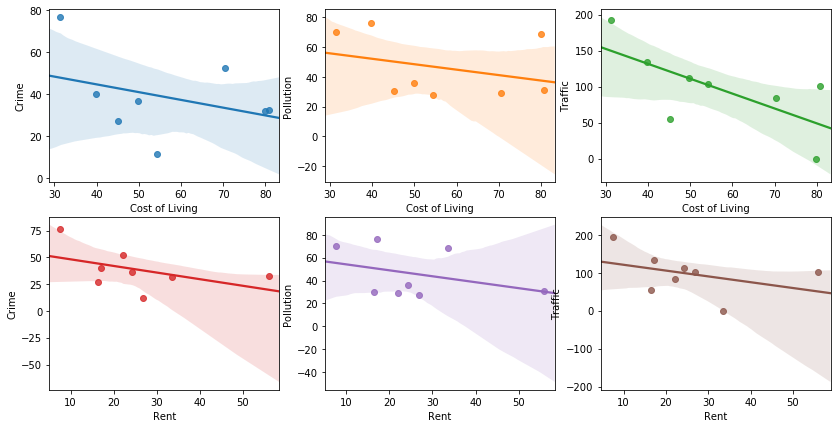

In [6]:
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(14, 7))
sns.regplot(x='Cost of Living', y='Crime', data=cities, ax=axs[0][0])
sns.regplot(x='Cost of Living', y='Pollution', data=cities, ax=axs[0][1])
sns.regplot(x='Cost of Living',y='Traffic', data=cities, ax=axs[0][2])
sns.regplot(x='Rent', y='Crime', data=cities, ax=axs[1][0])
sns.regplot(x='Rent', y='Pollution', data=cities, ax=axs[1][1])
sns.regplot(x='Rent',y='Traffic', data=cities, ax=axs[1][2])

Although the relationships between the cost indexes and the negative indexes are clearly negative, the slope of the line is not steep, which means weak correlations. The same happens with the relationships between cost indexes and positive indexes.

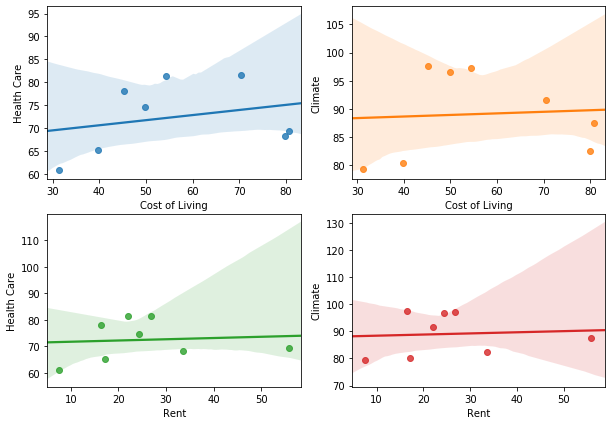

In [7]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(10, 7))
sns.regplot(x='Cost of Living', y='Health Care', data=cities, ax=axs[0][0])
sns.regplot(x='Cost of Living', y='Climate', data=cities, ax=axs[0][1])
sns.regplot(x='Rent', y='Health Care', data=cities, ax=axs[1][0])
sns.regplot(x='Rent', y='Climate', data=cities, ax=axs[1][1])

The weaknesses of those relationships (Cost Indexes x Negative Indexes and Cost Indexes x Positive Indexes) can be confirmed in the correlation matrices bellow.

In [3]:
cities[['Cost of Living', 'Rent', 'Crime', 'Pollution', 'Traffic']].corr()

,Cost of Living,Rent,Crime,Pollution,Traffic
Cost of Living,1.000000,0.833731,-0.356941,-0.319578,-0.682947
Rent,0.833731,1.000000,-0.466883,-0.355645,-0.395162
Crime,-0.356941,-0.466883,1.000000,0.469532,0.587757
Pollution,-0.319578,-0.355645,0.469532,1.000000,0.207473
Traffic,-0.682947,-0.395162,0.587757,0.207473,1.000000


In [4]:
cities[['Cost of Living', 'Rent', 'Health Care', 'Climate']].corr()

,Cost of Living,Rent,Health Care,Climate
Cost of Living,1.000000,0.833731,0.271370,0.066953
Rent,0.833731,1.000000,0.089006,0.078445
Health Care,0.271370,0.089006,1.000000,0.885980
Climate,0.066953,0.078445,0.885980,1.000000


#### 1.2 Pre-processing

Since the relationship among the variables are not trivial, in order to help in the decision of choosing a new city to move in, a clustering algorithm is applied to segment the cities according to the similarity of those indexes, allowing a deeper comparison among them. K-Means was used to this task.  

In order to allow K-Means to interpret equally features with different magnitudes and distributions, first they are normalized. 

In [5]:
from sklearn.preprocessing import StandardScaler
X = cities.values[:,1:]
X = np.nan_to_num(X)
data = StandardScaler().fit_transform(X)
data

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.44461722, -1.31871366,  0.68494705,  2.11245483, -1.61327921,
         1.19080519,  1.81341872, -1.34494562],
       [ 1.39761092,  2.23973752, -0.54465294, -0.34885148, -0.42046649,
        -0.76355538,  0.06342151, -0.22126358],
       [-0.64651634, -0.66551046, -0.84768823, -0.64174526,  0.79620249,
        -0.78763992, -0.82191808,  1.18024437],
       [-0.95759168, -0.61334237,  2.37471175,  0.07495696, -1.00424307,
         1.50189724,  0.68046487, -1.20465729],
       [-0.12096576,  0.09643748, -0.40373529, -1.49768298,  1.23824486,
        -0.92612606,  0.10269825,  1.12110321],
       [ 0.80306026, -0.24743102, -0.76288823,  0.7777911 ,  1.27332758,
        -0.84584424, -0.25174117,  0.348142  ],
       [-0.38029105, -0.08137486, -0.30521764, -0.10310915,  0.30504431,
        -0.50665355,  0.26435906,  1.03858066],
       [ 1.34931087,  0.59019738, -0.19547647, -0.37381402, -0.57483049,
         1.13711672, -1.85070317, -0.91720374]])

#### 1.3 Modeling

An initial k of 3 was chosen. The idea is to identify one group of cities similar to the current city (Recife) and at least 2 other groups to have different type of options to choose between.

In [6]:
k_means = KMeans(n_clusters = 3, n_init = 12)
k_means.fit(X)
cities['group'] = k_means.labels_
cities

,City,Cost of Living,Rent,Property Price,Crime,Health Care,Pollution,Traffic,Climate,group
0,Recife,31.31,7.51,20.56,76.81,60.95,69.85,193.11,79.28,1
1,Amsterdam,80.74,55.94,10.70,32.44,69.45,30.90,100.88,87.45,2
2,Aveiro,45.19,16.40,8.27,27.16,78.12,30.42,54.22,97.64,2
3,Guangzhou,39.78,17.11,34.11,40.08,65.29,76.05,133.40,80.30,1
4,Corunna,54.33,26.77,11.83,11.73,81.27,27.66,102.95,97.21,2
5,Nantes,70.40,22.09,8.95,52.75,81.52,29.26,84.27,91.59,2
6,Porto,49.82,24.35,12.62,36.87,74.62,36.02,111.47,96.61,2
7,Venice,79.90,33.49,13.50,31.99,68.35,68.78,0.00,82.39,0


#### 1.4 Insights 

Now it is possible to create a profile for each group considering the common characteristics of each cluster.

In [7]:
cities.groupby('group').mean()

,Cost of Living,Rent,Property Price,Crime,Health Care,Pollution,Traffic,Climate
group,,,,,,,,
0,79.900,33.49,13.500,31.990,68.350,68.780,0.000,82.39
1,35.545,12.31,27.335,58.445,63.120,72.950,163.255,79.79
2,60.096,29.11,10.474,32.190,76.996,30.852,90.758,94.10


Venice is a peculiar city and it was already expected to be alone in a group. It is highly touristic, predominantly historic, which makes the rent high, and presents 0 traffic due to the canals and the blocking of vehicles. Recife and Guangzhou are cheap cities to live, but present high values of negative indexes and low values of positive indexes. The others are Europeans cities with moderate to high cost indexes but that provide a notable life quality, presenting high values of health care and climate and low to moderate values of crime, pollution and traffic.

- Group 0 (Venice): peculiar city with particular features
- Group 1 (Recife and Guangzhou): cheap but mediocre quality of life
- Group 2 (Amsterdam, Aveiro, Corunna, Nates, and Porto): moderate to high life cost but good life quality

If you are not an artist or don't wish to work with tourism, Venice is not the best city to move in. On the other hand, Guangzhou presents similar problems to Recife. Thus the chosen city should be from Group 2. 

In [8]:
cities[cities.group == 2]

,City,Cost of Living,Rent,Property Price,Crime,Health Care,Pollution,Traffic,Climate,group
1,Amsterdam,80.74,55.94,10.70,32.44,69.45,30.90,100.88,87.45,2
2,Aveiro,45.19,16.40,8.27,27.16,78.12,30.42,54.22,97.64,2
4,Corunna,54.33,26.77,11.83,11.73,81.27,27.66,102.95,97.21,2
5,Nantes,70.40,22.09,8.95,52.75,81.52,29.26,84.27,91.59,2
6,Porto,49.82,24.35,12.62,36.87,74.62,36.02,111.47,96.61,2


Among the cities of Group 2, Aveiro presents the lowest Cost Indexes, high values of positive indexes and low values of negative indexes. However, other factors can influence in the decision, like the job market and the size of the city. Thus, instead of chosing Aveiro, **Amsterdam** was the choice.

### 2. Choosing the best neighborhood 

Now that the city is chosen, it is time to decide which neighborhood to live in. The decision will be based on the venues (restaurants, bars, cafes, museums, art galleries, parks, clubs, universities, schools, markets, services like laundry, etc) present in each neighborhood. That information is available on Foursquare, a local search-and-discovery mobile app that provides personalized recommendations of places to go near a user's current location. Foursquare provides an API that allows developers to interact with the Foursquare platform and to retrieve, among others contents, all sorts of information about the venues near a location.  
  
After the identification of the main venues in each neighborhood, the idea is to segment them according to the similarity of the type of venues they have. Finding the main venues will allow the characterization of each neighborhood and segmenting them according to the type of venues will obtain groups of similar neighborhoods, given options to the seeker. Once the most appropriated group of neighborhoods is chosen, to help in the final decision, information about crime rate by neighborhood is used.     

#### 2.1 Download and explore the dataset

First, it is necessary to get Amsterdam neighborhoods and their coordinates. Luckily this information is available for free at the municipal page.

In [9]:
neighborhoods = pd.read_excel("amsterdam_neighborhoods.xlsx")
neighborhoods.head()

,OBJECTNUMMER,Buurtcombinatie_code,Buurtcombinatie,Stadsdeel_code,Opp_m2,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT
0,1,A00,Burgwallen-Oude Zijde,A,404733,"POLYGON((4.903254 52.376582,4.902978 52.376682...","POLYGON((52.376582 4.903254,52.376682 4.902978...",4.897639,52.372281
1,2,A01,Burgwallen-Nieuwe Zijde,A,728412,"POLYGON((4.906409 52.380033,4.906006 52.380099...","POLYGON((52.380033 4.906409,52.380099 4.906006...",4.897123,52.374921
2,3,A02,Grachtengordel-West,A,569073,"POLYGON((4.894003 52.378758,4.893684 52.378894...","POLYGON((52.378758 4.894003,52.378894 4.893684...",4.888218,52.373334
3,4,A03,Grachtengordel-Zuid,A,641845,"POLYGON((4.90277 52.362797,4.901556 52.365154,...","POLYGON((52.362797 4.90277,52.365154 4.901556,...",4.892789,52.365037
4,5,A04,Nieuwmarkt/Lastage,A,1066820,"POLYGON((4.913608 52.372595,4.913585 52.373016...","POLYGON((52.372595 4.913608,52.373016 4.913585...",4.904444,52.372895


The needed information is just the neighborhood code (Buurtcombinatie_code), neighborhood name (Buurtcombinatie), longitude (LNG) and latitude (LAT). Then, English names will be given to those column names.

In [10]:
neighborhoods = neighborhoods.iloc[:,[1, 2, 7, 8]]
neighborhoods.columns = ['Code','Neighborhood','Longitude','Latitude']
neighborhoods

,Code,Neighborhood,Longitude,Latitude
0,A00,Burgwallen-Oude Zijde,4.897639,52.372281
1,A01,Burgwallen-Nieuwe Zijde,4.897123,52.374921
2,A02,Grachtengordel-West,4.888218,52.373334
3,A03,Grachtengordel-Zuid,4.892789,52.365037
4,A04,Nieuwmarkt/Lastage,4.904444,52.372895
...,...,...,...,...
94,T94,"Bijlmer Oost (E,G,K)",4.976832,52.319564
95,T95,Nellestein,4.992748,52.309565
96,T96,Holendrecht/Reigersbos,4.969496,52.296164
97,T97,Gein,4.993931,52.295510


Now, let's visualize all 99 Amsterdam neighborhoods in a map.

In [11]:
# Get Amsterdam location coordinates
geolocator = Nominatim(user_agent="ams_explorer")
location = geolocator.geocode("Amsterdam, NL")

map_amsterdam = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

# Add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

#### Getting top venues of each neighborhood

Let's get the top 100 venues that are in each neighborhood within a radius of 1 km. We are interested in their names, coordinates and category. Category values represent the type of the venue (Japanese restaurant, public park, library. etc) and they will be used to have an idea of the kind of places existent in a neighborhood, which will help in the decision of the neighborhood most suitable.

In [12]:
CLIENT_ID = 'TJNIF0UICB1EMN1LETJN0YNM5DARNO3JKGK4ZJ41RT4QRT5Q' # your Foursquare ID
CLIENT_SECRET = 'RGNFFRIQEWPAQLRLTDOXQVEIISJQWRFBOTSOJWLHDBAVHVWS' # your Foursquare Secret
VERSION = '20200624' # Foursquare API version

# Obtain the top 100 venues withing a radius of 1km for each location of a given list of coordinates (latitudes, longitudes)
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=1000, limit=100):
    
    venues_list=[]
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
venues = getNearbyVenues(neighborhoods=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'])
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Burgwallen-Oude Zijde,52.372281,4.897639,Rosalia's Menagerie,52.371678,4.899174,Cocktail Bar
1,Burgwallen-Oude Zijde,52.372281,4.897639,Sofitel Legend The Grand Amsterdam,52.371093,4.895410,Hotel
2,Burgwallen-Oude Zijde,52.372281,4.897639,De Koffieschenkerij,52.374043,4.898427,Coffee Shop
3,Burgwallen-Oude Zijde,52.372281,4.897639,Wynand Fockink,52.372301,4.895253,Liquor Store
4,Burgwallen-Oude Zijde,52.372281,4.897639,De Engelbewaarder,52.370231,4.898451,Bar


The folling table shows the amount of venues obtained for each neighborhood.

In [14]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amstel III/Bullewijk,40,40,40,40,40,40
Apollobuurt,97,97,97,97,97,97
Banne Buiksloot,23,23,23,23,23,23
Bedrijventerrein Sloterdijk,12,12,12,12,12,12
Betondorp,28,28,28,28,28,28
...,...,...,...,...,...,...
Westlandgracht,73,73,73,73,73,73
Willemspark,100,100,100,100,100,100
Zeeburgereiland/Nieuwe Diep,29,29,29,29,29,29


The total number of unique venue categories is:

In [15]:
len(venues['Venue Category'].unique())

319

#### 2.2 Pre-processing

The idea is to identify the most common types of places (venue categories) in each neighborhood. First, let's transform the venue categories into dummy variables.

In [16]:
# one hot encoding
venue_categories = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column as the first column
del venue_categories['Neighborhood']
venue_categories.insert(loc=0, column='Neighborhood', value=venues['Neighborhood'])

venue_categories.head()

,Neighborhood,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. This way we will see the frequency of each venue category in each neighborhood. The result is a table with 99 rows (amount of neighborhoods) and 315 columns (amount of venue categories).

In [17]:
venues_grouped = venue_categories.groupby('Neighborhood').mean().reset_index()
venues_grouped

,Neighborhood,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amstel III/Bullewijk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
1,Apollobuurt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.010309,0.0,0.00,0.0,0.0
2,Banne Buiksloot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
3,Bedrijventerrein Sloterdijk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
4,Betondorp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Westlandgracht,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.013699,0.0,0.00,0.0,0.0
95,Willemspark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.020000,0.0,0.01,0.0,0.0
96,Zeeburgereiland/Nieuwe Diep,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
97,Zuid Pijp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.02,0.010000,0.0,0.03,0.0,0.0


Lastly, let's create the new dataframe to display the top 10 venues for each neighborhood.

In [18]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amstel III/Bullewijk,Hotel,Coffee Shop,Restaurant,Fast Food Restaurant,Café,Bus Station,Metro Station,Bistro,Food Court,Food & Drink Shop
1,Apollobuurt,Hotel,Restaurant,Bakery,Italian Restaurant,Bistro,French Restaurant,Coffee Shop,Organic Grocery,Steakhouse,Gastropub
2,Banne Buiksloot,Bus Stop,Soccer Field,Boat or Ferry,Harbor / Marina,Farm,Sports Club,Tennis Court,Bakery,Restaurant,Grocery Store
3,Bedrijventerrein Sloterdijk,Motorcycle Shop,Furniture / Home Store,Restaurant,Breakfast Spot,Racetrack,Gas Station,Automotive Shop,Hardware Store,Zoo Exhibit,Drugstore
4,Betondorp,Soccer Field,Café,Playground,Stadium,Tennis Court,Scandinavian Restaurant,Drugstore,Bus Stop,Supermarket,Athletics & Sports


#### 2.3 Modeling

Now let's segment the neighborhoods according to the similarity of venue categories. For this, KMeans is used. To find the best K, the elbow method is applied. This method run the KMeans for each K value in a specified range and calculates a metric of accuracy for clustering. This metric can be the distance between data points and their cluster's centroid, which indicate how dense our clusters are. Then, those values are plotted and the elbow point is determined where the rate of decrease sharply shifts. The elbow point is the most suitable K.

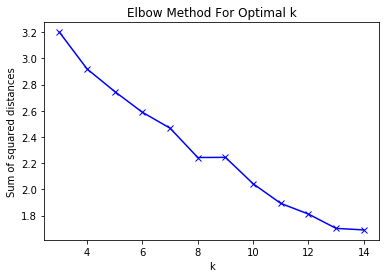

In [20]:
sum_squared_distances = []
K = range(3,15)
df = venues_grouped.iloc[:,1:]
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    sum_squared_distances.append(km.inertia_) # Calculates the sum of squared distances of samples to the nearest cluster centre
    
plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The ebow point is k=6. Now that the most suitable K is find, let's run the KMeans with this k value.

In [21]:
kclusters = 8
kmeans = KMeans(n_clusters = kclusters, n_init = 12)
kmeans.fit(venues_grouped.iloc[:,1:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now let's add the group labels to the top 10 venues dataset ans then merge it to the neighborhoods dataset.

In [22]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged_data = neighborhoods

# merge neighborhoods with venues_sorted to add latitude/longitude for each neighborhood
merged_data = merged_data.join(venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged_data.head()

,Code,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A00,Burgwallen-Oude Zijde,4.897639,52.372281,1,Hotel,Coffee Shop,Bar,French Restaurant,Café,Cocktail Bar,Dessert Shop,Thai Restaurant,Chinese Restaurant,Pub
1,A01,Burgwallen-Nieuwe Zijde,4.897123,52.374921,1,Hotel,Coffee Shop,French Restaurant,Bar,Burger Joint,Church,Beer Bar,Cocktail Bar,Chinese Restaurant,Pub
2,A02,Grachtengordel-West,4.888218,52.373334,1,Hotel,Bar,Bookstore,Café,Restaurant,French Restaurant,Dessert Shop,Cheese Shop,Clothing Store,Cocktail Bar
3,A03,Grachtengordel-Zuid,4.892789,52.365037,1,Italian Restaurant,Bar,Steakhouse,Coffee Shop,Marijuana Dispensary,Clothing Store,Hotel,Plaza,French Restaurant,Bookstore
4,A04,Nieuwmarkt/Lastage,4.904444,52.372895,1,Coffee Shop,Hotel,Bar,Restaurant,Pub,Plaza,Mediterranean Restaurant,Tea Room,Thai Restaurant,Café


Lastly, let's see the cluesters in a map.

In [23]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Neighborhood'], merged_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 2.4 Insights

Let's take a look in each cluster in order to characterize them.  

In [24]:
def get_cluster_neighborhoods(label):
    return merged_data.loc[merged_data['Cluster Labels'] == label, merged_data.columns[[1] + list(range(5, merged_data.shape[1]))]]

##### Cluster 1 - Area with many restaurants, cafes and supermarkets. Some hotels but not many, indicating a relative proximity of touristic areas. Some bars and clubs, indicating certain night life.

In [25]:
get_cluster_neighborhoods(0)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Sloterdijk,Restaurant,Hotel,Farm,Bus Stop,Music Venue,Café,Supermarket,Hostel,Bar,Gas Station
23,Landlust,Restaurant,Café,Park,Hostel,Supermarket,Coffee Shop,Fish Market,Garden,Ramen Restaurant,Lebanese Restaurant
25,De Kolenkit,Restaurant,Hotel,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Park,Turkish Restaurant,Bakery,Fast Food Restaurant,Nightclub
32,Slotermeer-Noordoost,Hotel,Turkish Restaurant,Park,Dessert Shop,Café,Recreation Center,Discount Store,Department Store,Kebab Restaurant,Metro Station
33,Slotermeer-Zuidwest,Turkish Restaurant,Café,Sporting Goods Shop,Park,Supermarket,Discount Store,Dessert Shop,Bus Stop,Metro Station,Drugstore
35,Eendracht,Soccer Field,Garden,General Entertainment,Baseball Field,Cafeteria,Trail,Event Space,Recreation Center,Stadium,Athletics & Sports
40,Middelveldsche Akerpolder,Tram Station,Trail,Hotel,Gym / Fitness Center,Boat or Ferry,Music Store,Supermarket,Garden Center,Tea Room,Bakery
41,Slotervaart Noord,Supermarket,Tram Station,Bakery,Indian Chinese Restaurant,Museum,Steakhouse,Restaurant,Pool,Playground,Pharmacy
42,Overtoomse Veld,Restaurant,Supermarket,Nightclub,Bar,Hotel,Coffee Shop,Tram Station,Gym,Ice Cream Shop,Bakery
43,Westlandgracht,Supermarket,Coffee Shop,Gym / Fitness Center,Hotel,Café,Bar,Restaurant,Italian Restaurant,Gym,Drugstore


##### Cluster 2 - Many restaurants, cafes and supermarkets. Many hotels and museums, indicating an area close to touristic attractions. Many bars and clubs suggesting a vivid night life. It seems to be the cultural center of the city. 

In [26]:
get_cluster_neighborhoods(1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Burgwallen-Oude Zijde,Hotel,Coffee Shop,Bar,French Restaurant,Café,Cocktail Bar,Dessert Shop,Thai Restaurant,Chinese Restaurant,Pub
1,Burgwallen-Nieuwe Zijde,Hotel,Coffee Shop,French Restaurant,Bar,Burger Joint,Church,Beer Bar,Cocktail Bar,Chinese Restaurant,Pub
2,Grachtengordel-West,Hotel,Bar,Bookstore,Café,Restaurant,French Restaurant,Dessert Shop,Cheese Shop,Clothing Store,Cocktail Bar
3,Grachtengordel-Zuid,Italian Restaurant,Bar,Steakhouse,Coffee Shop,Marijuana Dispensary,Clothing Store,Hotel,Plaza,French Restaurant,Bookstore
4,Nieuwmarkt/Lastage,Coffee Shop,Hotel,Bar,Restaurant,Pub,Plaza,Mediterranean Restaurant,Tea Room,Thai Restaurant,Café
5,Haarlemmerbuurt,Bar,Restaurant,Café,Italian Restaurant,Coffee Shop,Bistro,Thai Restaurant,Hotel,Cocktail Bar,French Restaurant
6,Jordaan,Bar,Hotel,Café,Cocktail Bar,Pizza Place,Italian Restaurant,Thai Restaurant,Coffee Shop,Restaurant,Ice Cream Shop
7,De Weteringschans,Coffee Shop,Art Museum,Steakhouse,Bar,Breakfast Spot,Vegetarian / Vegan Restaurant,Clothing Store,Restaurant,Hotel,Theater
8,Weesperbuurt/Plantage,Zoo Exhibit,Hotel,Bar,Restaurant,History Museum,Bakery,Theater,Museum,Breakfast Spot,Café
9,Oostelijke Eilanden/Kadijken,Zoo Exhibit,Restaurant,Café,Hotel,Breakfast Spot,Museum,Coffee Shop,Performing Arts Venue,Brewery,Gastropub


##### Cluster 3 - Beach area


In [27]:
get_cluster_neighborhoods(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,IJburg Oost,Beach,Skate Park,Campground,Beach Bar,Zoo Exhibit,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant


##### Cluster 4 - Isolated neighborhood probably rich/expensive since it presents a heliport and a harbor.

In [28]:
get_cluster_neighborhoods(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Westelijk Havengebied,Heliport,Bar,Harbor / Marina,Restaurant,Dive Bar,Doner Restaurant,Drugstore,Dutch Restaurant,Eastern European Restaurant,Electronics Store


##### Cluster 5 - Isolated regular area with venues specialized in vehicles.

In [29]:
get_cluster_neighborhoods(4)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Bedrijventerrein Sloterdijk,Motorcycle Shop,Furniture / Home Store,Restaurant,Breakfast Spot,Racetrack,Gas Station,Automotive Shop,Hardware Store,Zoo Exhibit,Drugstore


##### Cluster 6 - Isolated area with nature-related attractions

In [30]:
get_cluster_neighborhoods(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
97,Gein,Lake,Supermarket,IT Services,Playground,Bus Stop,Gym,Metro Station,Zoo Exhibit,Dutch Restaurant,Eastern European Restaurant


Cluster 7 - Area with venues for the practicing of different sports

In [31]:
get_cluster_neighborhoods(6)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
84,Kadoelen,Bus Stop,Boat or Ferry,Harbor / Marina,Soccer Field,Shopping Mall,Sports Club,Tennis Court,Gas Station,Road,Restaurant
87,Banne Buiksloot,Bus Stop,Soccer Field,Boat or Ferry,Harbor / Marina,Farm,Sports Club,Tennis Court,Bakery,Restaurant,Grocery Store


Cluster 8 - A regular residential area far from the center (the main spots are bus stops and tram stations), but with all basic stores (supermarket, bakery, restaurants, etc). It also presents options for recreation and sports. 

In [35]:
get_cluster_neighborhoods(7)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Geuzenveld,Bus Stop,Tram Station,Supermarket,Snack Place,Furniture / Home Store,Market,Drugstore,Greek Restaurant,Grocery Store,Track
36,Lutkemeer/Ookmeer,Clothing Store,Turkish Restaurant,Shopping Mall,Fast Food Restaurant,Café,Sandwich Place,Sporting Goods Shop,Piano Bar,Pet Store,BBQ Joint
37,Osdorp-Oost,Supermarket,Turkish Restaurant,Drugstore,Snack Place,Bakery,Pharmacy,Shopping Mall,Indonesian Restaurant,Clothing Store,Hotel
38,Osdorp-Midden,Supermarket,Tram Station,Bakery,Shopping Mall,Drugstore,Snack Place,Turkish Restaurant,Clothing Store,Hotel,Gym
39,De Punt,Tram Station,Hotel,Fast Food Restaurant,Bakery,Turkish Restaurant,Supermarket,Clothing Store,Dim Sum Restaurant,Discount Store,Snack Place
79,Tuindorp Nieuwendam,Convenience Store,Bus Stop,Indonesian Restaurant,Electronics Store,Supermarket,Bakery,Park,Harbor / Marina,Snack Place,Sandwich Place
80,Tuindorp Buiksloot,Bus Stop,Clothing Store,Convenience Store,Park,Supermarket,Café,Harbor / Marina,Market,Electronics Store,Nightclub
81,Nieuwendammerdijk/Buiksloterdijk,Clothing Store,Bus Stop,Convenience Store,Supermarket,Café,Bakery,Bar,Electronics Store,Camera Store,Campground
83,Oostzanerwerf,Bus Stop,Soccer Field,Creperie,Dutch Restaurant,Supermarket,Grocery Store,Design Studio,Rest Area,Snack Place,Spa
85,Waterlandpleinbuurt,Bus Stop,Plaza,Athletics & Sports,Supermarket,Indonesian Restaurant,Soccer Field,Snack Place,Seafood Restaurant,Gas Station,Discount Store


Given the clusters classification, the choice depends on each person and his/her tastes and life style. Here one of them is chosen a title of example. The neighborhoods of **Cluster 1** present all sort of attractions and utilities. It is not in the center but it is close, so it looks not so quiet nor not so noisy. Now let's use information about crimes incidence to help in the decision.     

#### Safety Index

The Amsterdam municipal page contains information about safety by neighborhood. It provides a table with a safety index for each neighborhood. The lower the index value the safer the neighborhood. More information about it can be find in https://data.amsterdam.nl/specials/dashboard/dashboard-veiligheid/d6006969-9d2a-413d-80a4-308932ed36f8/

In [36]:
neighborhood_safety_index = pd.read_excel('amsterdam_safety_data.xlsx', skiprows=5)
neighborhood_safety_index

,vmgebiednaam,vmgebied16nr,Unnamed: 2,veiligheidsindex,ipsl_risicoperceptie,ipsl_onveiligheidsgevoelens,ipsl_vermijding,Onveiligheidsbelevingindex,Ipersonenoverlast,Iverloedering,...,pop,nwoninge,nwink,nbedr,werkpers,student,bezoek,nbezoek,verbtot3,verbnieuw
0,A00,1,Burgwallen-Oude Zijde,178.10,136.67,99.27,84.26,106.73,507.91,143.21,...,4293,2917,222.0,1934,6233,1746,80626,88605,33828.00,16667.17
1,A01,2,Burgwallen-Nieuwe Zijde,168.84,122.61,94.46,73.79,96.95,453.97,130.80,...,4130,2884,594.0,2350,9428,1689,139692,150809,54399.67,24945.29
2,A02,3,Grachtengordel-West,79.61,110.42,52.24,45.99,69.55,132.56,100.52,...,6374,4314,245.0,3043,6989,0,43940,50929,23350.33,14196.17
3,A03,4,Grachtengordel-Zuid,137.45,112.97,65.40,45.37,74.58,268.80,127.85,...,5383,3449,177.0,1799,6350,0,29459,35809,17319.33,11182.04
4,A04,5,Nieuwmarkt/Lastage,120.79,117.95,75.90,68.92,87.59,203.33,119.49,...,9676,6190,128.0,2218,6830,2217,35470,44517,24515.00,16663.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,De Kwakel,104,De Kwakel,43.03,74.74,60.25,50.71,61.90,23.64,67.51,...,4435,1866,10.0,499,2017,0,1800,3817,5707.33,5332.33
104,Kudelstraart,105,Kudelstaart,58.24,88.06,74.61,90.44,84.37,42.52,79.35,...,9195,3763,18.0,454,600,0,2245,2845,10143.33,9675.63
105,Hornmeer,106,Aalsmeer Hornmeer,63.96,86.49,50.98,55.64,64.37,74.86,73.41,...,2540,1124,8.0,340,2262,0,1388,3650,3756.67,3467.50
106,Oost,107,Aalsmeer Oost,57.32,94.07,69.11,61.20,74.79,47.11,74.40,...,9880,3599,39.0,1031,2518,0,2776,5294,11644.67,11066.33


The needed information is only the neighborhood code (vmgebiednaam), the neighborhood name (Unnamed: 2) and the safety index (veiligheidsindex). Also the last lines are not necessary. They represent sub areas inside the neighborhoods.

In [37]:
neighborhood_safety_index = neighborhood_safety_index.iloc[0:91, [0, 2, 3]]
neighborhood_safety_index.columns = ['Code','Neighborhood','Safety index']
neighborhood_safety_index

,Code,Neighborhood,Safety index
0,A00,Burgwallen-Oude Zijde,178.10
1,A01,Burgwallen-Nieuwe Zijde,168.84
2,A02,Grachtengordel-West,79.61
3,A03,Grachtengordel-Zuid,137.45
4,A04,Nieuwmarkt/Lastage,120.79
...,...,...,...
86,T95,Nellestein,90.16
87,T96abc,Holendrecht/Reigersbos/N,106.98
88,T96defg(T92),Gaasperdam N/Z-Reigersbos M/Z,94.79
89,T97,Gein,94.45


The given table divide some neighborhoods into sub neighborhoods and merge some others into the same row. For example, neighborhood T96 is split into T96abc and T96defg, neighborhoods E15 and E16 are merged into E16/E15, neighborhoods F11 and F78 are merged into F78(F11), etc. First, let's merge the sub neighborhoods and split the merged ones in order to be able to plot them in a map. In the merging process, the final safety index is going to be the mean of the sub neighborhoods while in the split process the safety index will be replicated.       

In [38]:
import re

def get_neighborhood_name(code):
    row =  neighborhoods[neighborhoods.Code == code]
    if not row.empty: 
        return neighborhoods[neighborhoods.Code == code].iloc[0,1]
    else:
        return None

#split the merged neighborhoods
for i, row in neighborhood_safety_index.iterrows():
    row_code = row.Code
    if '(' in row_code:
        row_code = row_code.replace('(','/').replace(')', '')
    if '/' in row_code:
        split_codes = row_code.split('/')
        code1 = split_codes[0]
        neighborhood_safety_index.loc[i, 'Code'] = code1
        neighborhood_safety_index.loc[i, 'Neighborhood'] = get_neighborhood_name(code1)
        safety_index = row.loc['Safety index']
        for c in split_codes[1:]: 
            new_row = {'Code':c, 'Neighborhood':get_neighborhood_name(c), 'Safety index':safety_index}
            neighborhood_safety_index = neighborhood_safety_index.append(new_row, ignore_index=True)
            
#merge the slit neighborhoods
removed_subneighb_indexes=[]
subneighb_codes=[]
for i, row in neighborhood_safety_index.iterrows():
    row_code = row.Code
    if (re.search('[a-z]$', row_code) and row_code[0:3] not in subneighb_codes): # the codes must finish in a number. If the code finishes in a letter it is a sub neighborhood
        code = row_code[0:3] # The code of a neighborhood is the first 3 characters of the code of a sub neiborhood
        subneighb_codes.append(code)
        j = i + 1
        safety_indexes = [neighborhood_safety_index.loc[i, 'Safety index']]
        while (neighborhood_safety_index.loc[j, 'Code'][0:3] == code):
            safety_indexes.append(neighborhood_safety_index.loc[j, 'Safety index'])
            removed_subneighb_indexes.append(j)
            j = j + 1
        final_index = sum(safety_indexes)/len(safety_indexes) # The safety index of the neighborhood is the mean of its sub neighborhoods
        neighborhood_safety_index.loc[i, 'Code'] = code
        neighborhood_safety_index.loc[i, 'Neighborhood'] = get_neighborhood_name(code)
        neighborhood_safety_index.loc[i, 'Safety index'] = final_index

neighborhood_safety_index.drop(removed_subneighb_indexes,inplace=True)
neighborhood_safety_index.reset_index(drop=True, inplace=True)
neighborhood_safety_index

,Code,Neighborhood,Safety index
0,A00,Burgwallen-Oude Zijde,178.10
1,A01,Burgwallen-Nieuwe Zijde,168.84
2,A02,Grachtengordel-West,79.61
3,A03,Grachtengordel-Zuid,137.45
4,A04,Nieuwmarkt/Lastage,120.79
...,...,...,...
93,N72,Noordelijke IJ-oevers Oost,102.18
94,N63,Tuindorp Buiksloot,81.44
95,N64,Nieuwendammerdijk/Buiksloterdijk,81.44
96,N67,Kadoelen,84.81


Now let's merge the obtained dataframe with the neighborhoods dataframe to get the coordinates of each neighborhood an thus be able to plot the crime information in a map.

In [39]:
amsterdam_safety_index = pd.merge(neighborhood_safety_index, neighborhoods[['Code', 'Latitude', 'Longitude']], on='Code')
amsterdam_safety_index

,Code,Neighborhood,Safety index,Latitude,Longitude
0,A00,Burgwallen-Oude Zijde,178.10,52.372281,4.897639
1,A01,Burgwallen-Nieuwe Zijde,168.84,52.374921,4.897123
2,A02,Grachtengordel-West,79.61,52.373334,4.888218
3,A03,Grachtengordel-Zuid,137.45,52.365037,4.892789
4,A04,Nieuwmarkt/Lastage,120.79,52.372895,4.904444
...,...,...,...,...,...
93,N72,Noordelijke IJ-oevers Oost,102.18,52.384194,4.935628
94,N63,Tuindorp Buiksloot,81.44,52.393208,4.929079
95,N64,Nieuwendammerdijk/Buiksloterdijk,81.44,52.393553,4.933584
96,N67,Kadoelen,84.81,52.416180,4.909158


In order to create a Choropleth map, a GeoJSON file that defines the areas/boundaries of Amsterdam neighborhoods is needed. This file can be find in the Amsterdam municipal page: https://maps.amsterdam.nl/open_geodata/geojson.php?KAARTLAAG=GEBIED_BUURTCOMBINATIES&THEMA=gebiedsindeling. A choropeth map with the Safety index by neighborhood was added to the map of the clustered Amsterdam neighborhoods. The top 10 venues were added to the label of each point to concise all the needed information in one map, facilitating the decision about which neighborhood to live.  

In [40]:
# create map
map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

amsterdam_geo = r'amsterdam_neighborhoods.json' # geojson file

# generate choropleth map using the Safety index of each neighborhood
map_clusters.choropleth(
    geo_data=amsterdam_geo,
    data=amsterdam_safety_index,
    columns=['Code', 'Safety index'],
    key_on='feature.properties.Buurtcombinatie_code',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Safety index'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

def get_top10_label(neighborhood):
    top10 = merged_data[merged_data.Neighborhood == neighborhood].iloc[0,5:]
    top10_label = ''
    for i in range(0,9):
        top10_label = top10_label + top10[i] + ', '
    return top10_label + top10[9]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Neighborhood'], merged_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ': ' + get_top10_label(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters